In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import pandas as pd
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader
import argparse
from model.stereo_hiruma import stereo_hiruma_att
from utils import draw_subplot, normalize

import PIL
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.animation as anm

class dataset(Dataset):
    def __init__(self,left, right, pos):
        self.left = left
        self.right = right
        self.pos = pos
        assert self.left.shape[0] == self.pos.shape[0] == self.right.shape[0]

    def __len__(self):
        return self.pos.shape[0]

    def __getitem__(self, idx):
        return self.left[idx],self.right[idx],self.pos[idx]


c:\Users\Ogata\miniconda3\envs\mhitorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(150, 51, 6) (150, 51, 3, 112, 112)
Load Data done


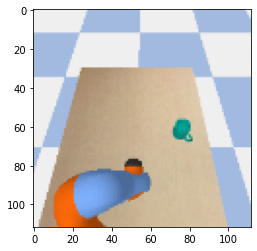

In [2]:
data_id = '20220528_203023'
train_dir ='D:/data/normalize/{}/train/'.format(data_id)
test_dir = 'D:/data/normalize/{}/test/'.format(data_id)

train_csv = np.load(os.path.join(train_dir,'joint.npy'))
test_csv = np.load(os.path.join(test_dir,'joint.npy'))
train_left = np.load(os.path.join(train_dir,'left_img.npy'))
train_right = np.load(os.path.join(train_dir,'right_img.npy'))
test_left = np.load(os.path.join(test_dir,'left_img.npy'))
test_right = np.load(os.path.join(test_dir,'right_img.npy'))

plt.imshow(train_left[0][0].transpose(1,2,0))
print(train_csv.shape, train_left.shape)

train_dataset = dataset(train_left, train_right, train_csv)
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, drop_last=True)
test_dataset = dataset(test_left, test_right, test_csv)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)
print("Load Data done")

In [9]:
# model path
training_id = "20220604_140628"
model_path = 'D:/logs/stereo/%s/models/model_550.pth'%(training_id)
print("model_path:", model_path)

# load model
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = stereo_hiruma_att(device)
model.load_state_dict(torch.load(model_path,map_location=device))
model.to(device)
model.eval()
criterion = torch.nn.L1Loss()
loss_coef = [1.0, 0.1, 0.001, 0.0001]
print('Start online prediction')


# randm seed
seed = 42
np.random.seed(seed)  # Numpy module.
torch.manual_seed(seed) # 为CPU设置随机种子
torch.cuda.manual_seed(seed) # 为当前GPU设置随机种子
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU，为所有GPU设置随机种子
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

model_path: D:/logs/stereo/20220604_140628/models/model_550.pth
Start online prediction


In [13]:
with torch.no_grad():
    pred_left = []
    pred_right = []
    pred_pos = []
    left = []
    right = []
    pos = []
    left_map = []
    right_map = []
    for test_left, test_right, test_position in train_dataloader:
        model.eval()
        test_loss, test_position_loss, test_left_loss, test_right_loss = 0., 0., 0., 0.
        test_rnn_hidden = None
        test_position =test_position.to(device).float()
        test_left = test_left.to(device).float()
        test_right = test_right.to(device).float()
        for steps in range(49+3):
            if steps < 3:
                steps = 0
            else:
                steps = steps-3
            t_test_position = test_position[:,steps,:]
            t_test_left = test_left[:,steps,:]
            t_test_right = test_right[:,steps,:]

            t_pred_left, t_pred_right, t_test_position, map1, map2,t_pt, pt, test_rnn_hidden = model(t_test_left, t_test_right, t_test_position, test_rnn_hidden)
            pred_left.append(t_pred_left.cpu().detach().numpy())
            pred_right.append(t_pred_right.cpu().detach().numpy())
            pred_pos.append(t_test_position.cpu().detach().numpy())
            left.append(test_left[:,steps+1,:].cpu().detach().numpy())
            right.append(test_right[:,steps+1,:].cpu().detach().numpy())
            pos.append(test_position[:,steps+1,:].cpu().detach().numpy())
            map1 = map1.view(-1, 4, 24, 24)
            map2 = map2.view(-1, 4, 24, 24)
            left_map.append(map1.cpu().detach().numpy())
            right_map.append(map2.cpu().detach().numpy())
        break
pred_left = np.array(pred_left)
pred_right = np.array(pred_right)
pred_pos = np.array(pred_pos)
pos = np.array(pos)
left = np.array(left)
right = np.array(right)
left_map = np.array(left_map).squeeze(axis=1)
right_map = np.array(right_map).squeeze(axis=1)
print(pred_pos.shape, pos.shape, pred_left.shape, left.shape, left_map.shape)

(52, 1, 6) (52, 1, 6) (52, 1, 3, 112, 112) (52, 1, 3, 112, 112) (52, 4, 24, 24)


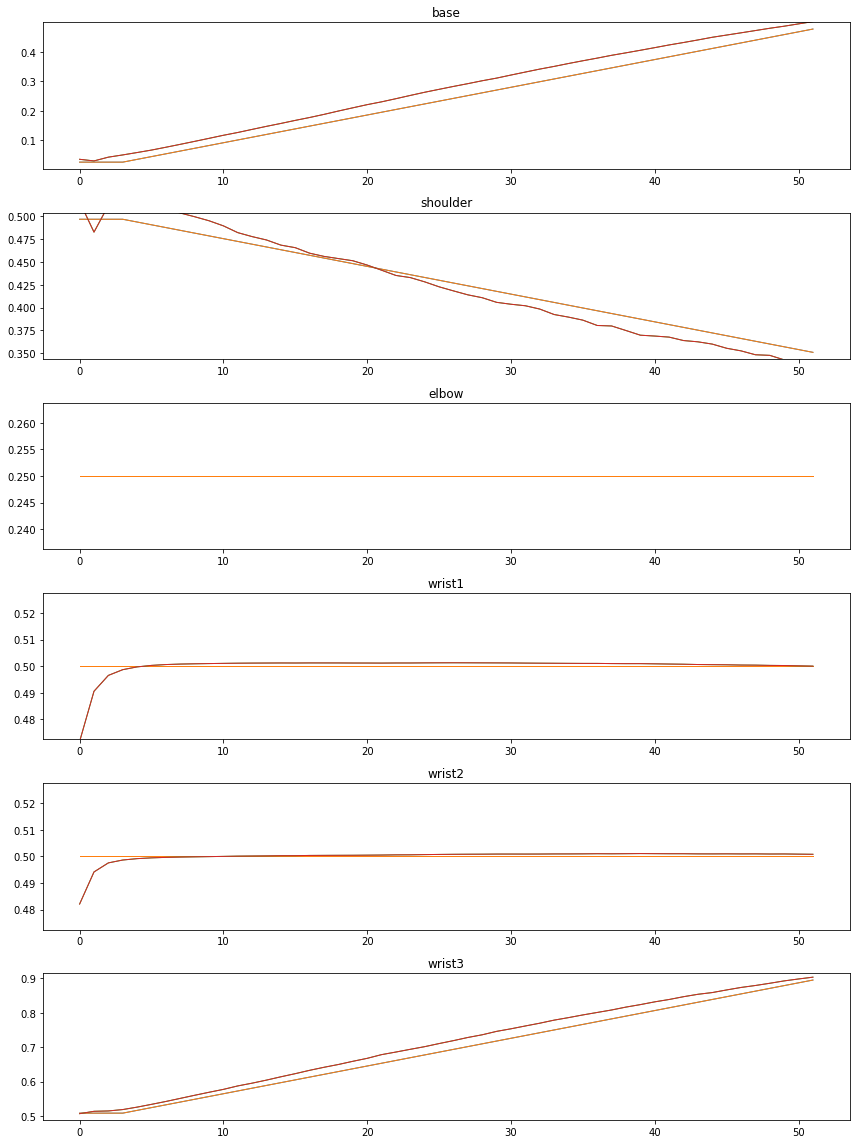

In [14]:
xyz=["base","shoulder","elbow","wrist1","wrist2","wrist3"]
plt.figure(figsize=(12,16))
steps = range(len(pos))
for i in range(6):
    true_one_position = np.concatenate((pos[:,0,i].reshape(-1,1),pos[:,0,i].reshape(-1,1)), axis=1)
    pred_one_position = np.concatenate((pred_pos[:,0,i].reshape(-1,1),pred_pos[:,0,i].reshape(-1,1)), axis=1)
    draw_subplot(steps, true_one_position, (6,1,i+1), title=xyz[i])
    draw_subplot(steps, pred_one_position, (6,1,i+1), title=xyz[i])

plt.tight_layout()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


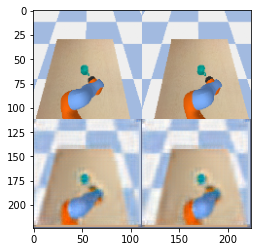

In [15]:
i = 51
true_img = np.concatenate((left[i][0].transpose(1,2,0), right[i][0].transpose(1,2,0)),axis=1)
pred_img = np.concatenate((pred_left[i][0].transpose(1,2,0), pred_right[i][0].transpose(1,2,0)),axis=1)
img = np.concatenate((true_img, pred_img),axis=0)
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

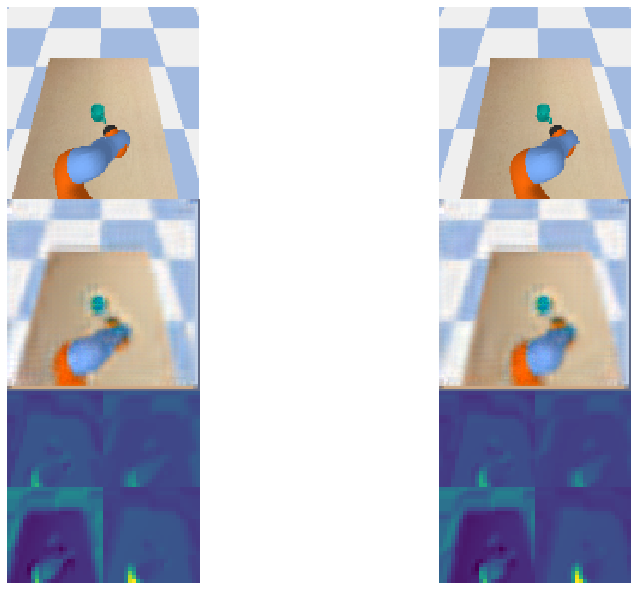

In [16]:
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import matplotlib.animation as anim
figure = plt.figure(figsize=(12, 8))
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
gs_master = GridSpec(nrows=3, ncols=2, height_ratios=[1, 1, 1], width_ratios=[1, 1])

gs_1 = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec=gs_master[0, 0])
axes_1 = figure.add_subplot(gs_1[:, :])
axes_1.set_axis_off() 

gs_2 = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec=gs_master[0, 1])
axes_2 = figure.add_subplot(gs_2[:, :])
axes_2.set_axis_off() 

gs_3 = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec=gs_master[1, 0])
axes_3 = figure.add_subplot(gs_3[:, :])
axes_3.set_axis_off() 

gs_4 = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec=gs_master[1, 1])
axes_4 = figure.add_subplot(gs_4[:, :])
axes_4.set_axis_off() 

gs_5 = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec=gs_master[2, 0])
axes_5 = figure.add_subplot(gs_5[:, :])
axes_5.set_axis_off() 

gs_6 = GridSpecFromSubplotSpec(nrows=1, ncols=1, subplot_spec=gs_master[2, 1])
axes_6 = figure.add_subplot(gs_6[:, :])
axes_6.set_axis_off() 

def anim_update(i):
        
        left_attmap = left_map
        right_attmap = right_map

        axes_1.imshow(left[i][0].transpose(1,2,0),interpolation='nearest')
        axes_2.imshow(right[i][0].transpose(1,2,0),interpolation='nearest')

        axes_3.imshow(pred_left[i][0].transpose(1,2,0),interpolation='nearest')
        axes_4.imshow(pred_right[i][0].transpose(1,2,0),interpolation='nearest')

        left_up = np.concatenate([left_attmap[i][0], left_attmap[i][1]], axis=1)
        left_down = np.concatenate([left_attmap[i][2], left_attmap[i][3]], axis=1)
        left_sum = np.concatenate([left_up, left_down], axis=0)

        right_up = np.concatenate([right_attmap[i][0], right_attmap[i][1]], axis=1)
        right_down = np.concatenate([right_attmap[i][2], right_attmap[i][3]], axis=1)
        right_sum = np.concatenate([right_up, right_down], axis=0)

        axes_5.imshow(left_sum,interpolation='nearest')
        axes_6.imshow(right_sum,interpolation='nearest')

ani = anm.FuncAnimation(figure, anim_update, interval=100, frames=50)
ani.save('stereo_eval_test8.gif',writer = 'pillow')